## Process files in S3 folder

In [6]:
S3_FOLDER_PATH = "../datasets/s3"

In [28]:
import re

def process_type_1(text: str) -> list[str]:
    """
    Processes text where sentences are separated by spaces, but without punctuation.
    Inserts '。' and returns a list of sentences.
    """
    # Split by space, remove empty parts
    parts = [part.strip() for part in text.split() if part.strip()]
    # Add Chinese period to each sentence
    return [part + '。' for part in parts]

def process_type_2(text: str) -> list[str]:
    """
    Splits sentences using Chinese sentence-ending punctuation: 。！？.
    Cleans and returns a list of complete sentences.
    """
    # Normalize spacing
    text = re.sub(r'\s*([，。！？；：])\s*', r'\1', text)

    # Split by sentence-ending punctuation while preserving it
    parts = re.split(r'(?<=[。！？])', text)
    sentences = [s.strip() for s in parts if s.strip()]
    return sentences

def process_type_3(text: str) -> list[str]:
    lines = text.strip().splitlines()
    processed = []
    for line in lines:
        # Remove non-Chinese characters
        clean = ''.join(re.findall(r'[\u4e00-\u9fff，。！？；]', line))
        if clean:
            # Split by sentence-ending punctuation
            parts = re.split(r'(?<=[。！？])', clean)
            for p in parts:
                s = p.strip()
                if s and not s.endswith(('。', '？', '！')):
                    s += '。'
                if s:
                    processed.append(s)
    return processed

## Test

In [29]:
# Type 1
text1 = "Hello 大家好 现在是星期五的晚上 现在是晚上7点"
print(process_type_1(text1))

# Type 2
text2 = "这是我家， 我家。 我家里有很多家务。 家务， 很多家务。"
print(process_type_2(text2))

# Type 3
text3 = """1. 今天的天气非常好。
2. 夏天的炎热天气让我们无法外出。
3. 风起云散，是一个美丽的天气。"""
print(process_type_3(text3))

['Hello。', '大家好。', '现在是星期五的晚上。', '现在是晚上7点。']
['这是我家，我家。', '我家里有很多家务。', '家务，很多家务。']
['今天的天气非常好。', '夏天的炎热天气让我们无法外出。', '风起云散，是一个美丽的天气。']


# Collect all sentences from s3

In [12]:
!pip install jieba

You should consider upgrading via the '/Users/danilkladnitsky/.pyenv/versions/3.10.4/bin/python3.10 -m pip install --upgrade pip' command.


In [30]:
import os
import re
import jieba

def collect_txt_files(folder: str) -> list[str]:
    txt_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.txt'):
                txt_files.append(os.path.join(root, file))
    return txt_files

def detect_and_process(text: str) -> list[str]:
    if re.search(r'^\d+\.', text.strip(), re.M):  # numbered lines
        return process_type_3(text)
    elif '。' in text:
        return process_type_2(text)
    else:
        return process_type_1(text)

def is_pinyin(text: str) -> bool:
    """Check if the string is mostly Pinyin (Latin letters and tone marks)."""
    return re.fullmatch(r"[a-zA-Zāáǎàōóǒòēéěèīíǐìūúǔùǖǘǚǜńň]+[。．]?", text) is not None

def is_valid_sentence(sentence: str) -> bool:
    """Check if the sentence has at least 3 Chinese words using jieba."""
    tokens = list(jieba.cut(sentence))
    chinese_tokens = [t for t in tokens if re.search(r'[\u4e00-\u9fff]', t)]
    return len(chinese_tokens) >= 3

def is_pure_chinese(sentence: str) -> bool:
    """
    Returns True if the sentence contains only Chinese characters and common Chinese punctuation.
    """
    allowed = re.compile(r'^[\u4e00-\u9fff，。！？；：「」‘’“”（）…—、]*$')
    return bool(allowed.fullmatch(sentence.strip()))

def process_folder(folder: str) -> list[str]:
    all_sentences = []
    for path in collect_txt_files(folder):
        with open(path, 'r', encoding='utf-8') as f:
            content = f.read()
        sentences = detect_and_process(content)

        # Filter Pinyin, short sentences, and non-Chinese sentences
        filtered = [
            s for s in sentences
            if not is_pinyin(s.strip()) 
            and is_valid_sentence(s)
            and is_pure_chinese(s)
        ]
        all_sentences.extend(filtered)
    return all_sentences

In [31]:
all_chinese_sentences = process_folder(S3_FOLDER_PATH)

len(all_chinese_sentences)

4043

## Save to single file

In [32]:
def save_sentences_to_file(sentences: list[str], output_path: str) -> None:
    """
    Saves a list of sentences to a text file, one per line.
    """
    with open(output_path, 'w', encoding='utf-8') as f:
        for sentence in sentences:
            f.write(sentence.strip() + '\n')

In [59]:
SAVE_TO = '../datasets/s3_sentences.txt'

sentences = process_folder(S3_FOLDER_PATH)
save_sentences_to_file(sentences, SAVE_TO)

# Divide by hsk levels

In [66]:
import os
import re
import jieba

def load_hsk_vocab(root_path: str, levels: list[int]) -> dict[int, set[str]]:
    vocab = {}
    for level in levels:
        path = os.path.join(root_path, f'hsk{level}.txt')
        with open(path, 'r', encoding='utf-8') as f:
            words = {line.strip() for line in f if line.strip()}
            vocab[level] = words
    return vocab

def filter_sentences_by_vocab(
    input_path: str,
    output_path: str,
    allowed_vocab: set[str]
) -> None:
    """
    Only keep unique sentences where ALL words (from jieba) are in allowed_vocab.
    """
    with open(input_path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    filtered = []
    seen = set()

    for sentence in sentences:
        if sentence in seen:
            continue

        words = list(jieba.cut(sentence))
        chinese_words = [w for w in words if re.search(r'[\u4e00-\u9fff]', w)]

        if all(w in allowed_vocab for w in chinese_words):
            filtered.append(sentence)
            seen.add(sentence)

    with open(output_path, 'w', encoding='utf-8') as f:
        for s in filtered:
            f.write(s + '\n')

In [68]:
HSK_VOCABULARY_ROOT_PATH = "../datasets/vocabulary"
HSK_LEVELS = [1, 2, 3]
INPUT_PATH = '../datasets/s3_sentences.txt'
OUTPUT_PATH = '../datasets/s3_sentences_hsk1.txt'

# Load vocabularies
vocab_map = load_hsk_vocab(HSK_VOCABULARY_ROOT_PATH, HSK_LEVELS)

# Combined vocab for checking inclusion
combined_vocab = set().union(*vocab_map.values())

level_1_vocab = vocab_map[1]
level_2_vocab = vocab_map[2]
level_3_vocab = vocab_map[3]

filter_sentences_by_vocab(
    input_path=INPUT_PATH,
    output_path='../datasets/s3_sentences_hsk1.txt',
    allowed_vocab=level_1_vocab
)

filter_sentences_by_vocab(
    input_path=INPUT_PATH,
    output_path='../datasets/s3_sentences_hsk2.txt',
    allowed_vocab=level_2_vocab
)

filter_sentences_by_vocab(
    input_path=INPUT_PATH,
    output_path='../datasets/s3_sentences_hsk3.txt',
    allowed_vocab=level_3_vocab
)




# Word distribution

In [71]:
!pip install matplotlib

You should consider upgrading via the '/Users/danilkladnitsky/.pyenv/versions/3.10.4/bin/python3.10 -m pip install --upgrade pip' command.


In [76]:
import jieba
import re
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib

def load_vocab(path: str) -> set[str]:
    with open(path, 'r', encoding='utf-8') as f:
        return {line.strip() for line in f if line.strip()}

def plot_word_distribution(txt_path: str, hsk_vocab_path: str, top_n: int = 30) -> None:
    """
    Plots a bar chart showing frequency of HSK words in the dataset with Chinese font support.
    """

    # Try to set a font that supports Chinese
    try:
        plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows/Ubuntu (if SimHei installed)
        plt.rcParams['axes.unicode_minus'] = False    # Fix minus sign issue
    except:
        print("Warning: Failed to set Chinese font.")

    # Load HSK vocab
    hsk_vocab = load_vocab(hsk_vocab_path)

    # Read and tokenize
    with open(txt_path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    word_counts = Counter()
    for sentence in sentences:
        words = jieba.cut(sentence)
        for word in words:
            if re.search(r'[\u4e00-\u9fff]', word) and word in hsk_vocab:
                word_counts[word] += 1

    # Get most common words
    most_common = word_counts.most_common(top_n)
    if not most_common:
        print("No HSK words found in dataset.")
        return

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} HSK Words in Dataset")
    plt.xlabel("词语")
    plt.ylabel("出现次数")
    plt.tight_layout()
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/var/folders/p9/gl1s91rn2fv_77662_261gb80000gn/T/ipykernel_14029/1008219794.py:51: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/var/folders/p9/gl1s91rn2fv_77662_261gb80000gn/T/ipykernel_14029/1008219794.py:51: UserWarning: Glyph 20320 (\N{CJK UNIFIED IDEOGRAPH-4F60}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/var/folders/p9/gl1s91rn2fv_77662_261gb80000gn/T/ipykernel_14029/1008219794.py:51: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tig

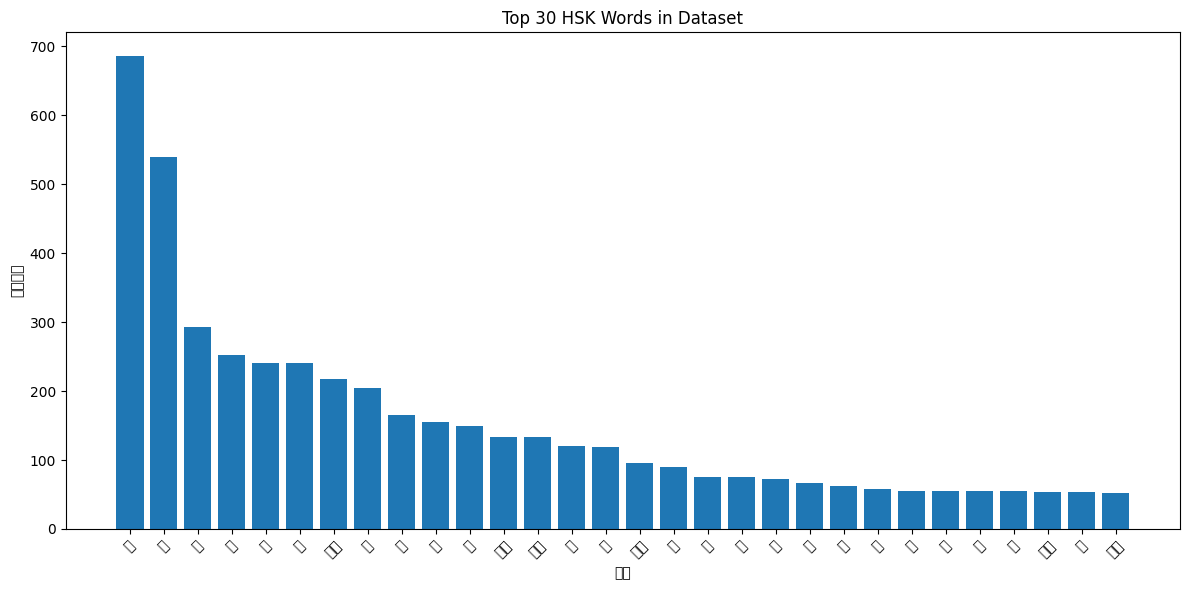

In [80]:
plot_word_distribution(
    txt_path='../datasets/s3_sentences_hsk2.txt',
    hsk_vocab_path='../datasets/vocabulary/hsk2.txt',
    top_n=30
)

# Generate labeled dataset

In [69]:
import json
import jieba
import re

def generate_prompt_samples(input_txt_path: str, output_jsonl_path: str) -> None:
    """
    Reads sentences from a text file, tokenizes them with jieba, and generates
    JSONL lines like {"prompt": "请用词语“X”造句：", "completion": "...", "word": "X"}
    for each word in each sentence (excluding punctuation).
    """
    with open(input_txt_path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    samples = []
    seen = set()

    for sentence in sentences:
        words = list(jieba.cut(sentence))
        for word in words:
            # Skip punctuation or non-Chinese tokens
            if not re.search(r'[\u4e00-\u9fff]', word):
                continue

            key = (word, sentence)
            if key in seen:
                continue

            sample = {
                "prompt": f"请用词语“{word}”造句：",
                "completion": sentence,
                "word": word
            }
            samples.append(sample)
            seen.add(key)

    # Write as JSONL
    with open(output_jsonl_path, 'w', encoding='utf-8') as f:
        for sample in samples:
            f.write(json.dumps(sample, ensure_ascii=False) + '\n')

In [79]:
generate_prompt_samples(
    input_txt_path='../datasets/s3_sentences_hsk3.txt',
    output_jsonl_path='../datasets/s3_prompts_hsk3.jsonl'
)